In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../../'); from config import *
configure_pylab()

Available files:
	r2288_180515b_tet2_cell2_GC.mat
	r2289_250515b_tet2_cell2_GC.mat
	r2298_290615c_tet6_cell6_GC.mat
	r2375_070416a_tet1_cell1_GC.mat
	r2375_140416b_tet1_cell1_GC.mat
	r2375_210416a_tet3_cell3_GC.mat
	r2383_160516b_tet4_cell4_GC.mat
	r2405_011216a_cell2955.mat
	r2405_051216b_cell1816.mat
	r2405_121216b_cell1880.mat
	r2405_121216b_cell1912.mat
	r2405_191216c_cell1640.mat
	r2405_191216c_cell1662.mat
	r2405_191216c_cell1962.mat
	r2405_191216c_cell1990.mat
Fitted models in fitdir = /home/mer49/Desktop/lgcpspatial/python/notebooks/hyperparameter_fits/


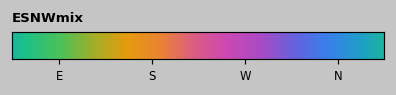

In [2]:
# Plot helpers
def quickpeaks(s):
    return (
        (s>roll(s, 1,1))&
        (s>roll(s,-1,1))&
        (s>roll(s, 1,2))&
        (s>roll(s,-1,2))&
        (s>roll(s, 1,(1,2)))&
        (s>roll(s,-1,(1,2)))&
        (s>roll(s,(1,-1),(1,2)))&
        (s>roll(s,(-1,1),(1,2))))
def hmix(y,cmap,pc=99):
    y = unitscale(y)
    c = cmap(linspace(0,1,y.shape[0]+1))[:-1,:3]
    rgb = einsum('dc,dhw->hwc',c,y)
    rgb = unitscale(rgb,q0=100-pc,q1=pc)
    return clip(rgb,0,1)
def preview_cmap(cmap,order='WSEN'):
    figure(0,(4,.3),120,facecolor=(.65,)*4)
    imshow(cmap([(linspace(0,1,360)-.125)%1]),aspect='auto')
    nox(); noy()
    xticks(linspace(0,2*pi,5)[:4]*360/(2*pi)+360*.125,order)
    title(cmap.name,loc='left',fontweight='bold')
preview_cmap(ESWNmix,'ESWN')
savefig('fig5v6_part_colorbar.pdf')

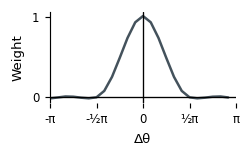

In [3]:
# Heading kernel
D   = 24
θs  = fftshift(linspace(-pi,pi,D+1)[:-1])
khp = maximum(0,cos(θs))**2
khp = ifft(maximum(0,fft(khp).real)).real

figure(0,(2,1),120,facecolor='w')
plot(linspace(-pi,pi,D+1)[:-1],fftshift(khp))
axvline(0,color='k',lw=0.8)
axhline(0,color='k',lw=0.8)
simpleraxis()
xticks(linspace(-pi,pi,5),['-π', '-½π', '0', '½π', 'π'])
yticks([0,1])
ylabel('Weight')
xlabel('Δθ')
savefig('fig5v6_part_headingkernel.pdf')

r2288_180515b_tet2_cell2_GC.mat
μ iter 0, ε=1.2587e+02
μ iter 1, ε=1.9993e+02
μ iter 2, ε=6.7511e+01
μ iter 3, ε=1.2208e+01
μ iter 4, ε=2.0587e+00
μ iter 5, ε=1.4684e-01
μ iter 6, ε=2.8893e-03
μ iter 7, ε=2.6237e-05
v iter 0, ε=3.6229e-01
μ iter 0, ε=3.1298e+01
μ iter 1, ε=1.1206e+00
μ iter 2, ε=4.6254e-03
μ iter 3, ε=5.1261e-05
v iter 0, ε=2.8855e-03
μ iter 0, ε=7.9913e-02
μ iter 1, ε=5.1579e-04
μ iter 2, ε=8.0711e-06
v iter 0, ε=4.3154e-05


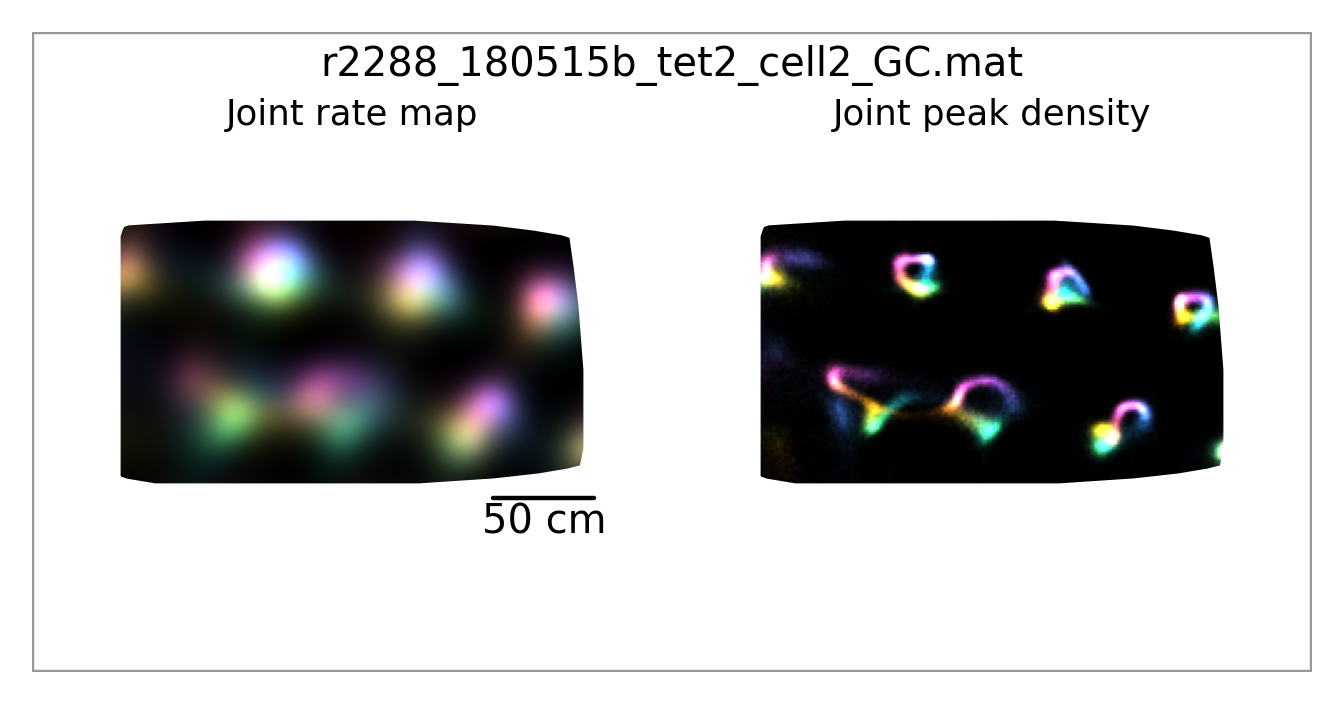

In [4]:
L  = 128
NKEEP    = 1000
NSAMPLES = 2**10

fn = 'r2405_191216c_cell1990.mat' # Weak but still interesting
fn = 'r2375_070416a_tet1_cell1_GC.mat' # Slightly disordered
fn = 'r2288_180515b_tet2_cell2_GC.mat' # Best
print(fn)

data   = Dataset.from_file(datadir+fn).prepare(L)
arena  = data.arena
saveto = fn[:-4]+'.hyperparameters.p'
P,V,θ  = pickle.load(open(fitdir+saveto,'rb'))
kernel = kernelft(data.shape,P,V,style='grid',angle=θ)
result = lgcp2d(kernel,data.N,data.Y,data.prior_mean)[0]
H,W    = data.shape
SHAPE  = (D,H,W)

sx,sy  = data.smoothed_position(Fl=2.0)
hg = data.smoothed_heading_angle(Fl=2.0)
hd = data.smoothed_head_direction(Fl=2.0)
h  = hd # Use head direction

# Joint kernel as tensor product of heading ⊗ (x,y)
kxp  = ifftn(kernel).real
khxf = fftn(ndouter(khp,kxp)).real
q    = (NKEEP-1)/(np.prod(SHAPE)-1)*100
th   = nanpercentile(khxf.ravel()[1:],100-q)
kept = khxf>th
khxf*= kept

# Bin by position and heading
nh    = ((h+2*pi)%(2*pi))/(2*pi)
nx,ny = data.arena.nx, data.arena.ny
nhyx  = float32([nh,ny,nx])
wrap  = (True,False,False)
N = bin_points(nhyx,SHAPE,None,wrap)
K = bin_points(nhyx,SHAPE,data.spikes,wrap)

# Fit heading–position joint model.
result,model = lgcpheading(
    khxf,N,K,data.prior_mean,
    eps=1e-5,mintol=1e-5,tol=1e-4,verbose=True)

# Sample joint peak density map
s = float32(parmap(model.sample,full(8,NSAMPLES//8)))
s = s.transpose(1,2,3,0,4).reshape(D,H,W,NSAMPLES)
radius = P/2.5
hpeaks = parmap(lambda sh:peak_density(sh,2,radius),s)

# Summarry figure
figure(0,(4,2),320,facecolor='w')
subplots_adjust(0,0,1,1,0,0)
subplot(121)
rgb = hmix([ri/nanmean(ri[arena.mask]) for ri in result.info.r],ESWNmix,99.7)
arena.imshow(clip(fft_upsample_2D(rgb.T,6).T,0,1))
px,py = arena.perim_m.T
xscalebar(np.max(px)-.25,.50,'50 cm',np.max(py)-px2y(5))
title('Joint rate map',pad=0)
subplot(122)
rgb = hmix(hpeaks,ESWNmix)
arena.imshow(rgb)
title('Joint peak density',pad=0)
figurebox()
suptitle(fn)
savefig('fig5v6b_%s.pdf'%fn)
savefig('fig5v6b_%s.svg'%fn)
show()